In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from datetime import datetime
import math
from tabulate import tabulate # print dataframes as tables
import matplotlib.dates as mdates
from scipy import stats

Covid Ages Data from https://data.ca.gov/dataset/covid-19-cases/resource/926fd08f-cc91-4828https://data.ca.gov/dataset/covid-19-cases/resource/926fd08f-cc91-4828-af38-bd45de97f8c3-af38-bd45de97f8c3

In [2]:
# read covid age demographics
covid_ages = pd.read_csv('data/case_demographics_age.csv')
covid_ages.head()

# lots of missing data at beginning -> perhaps because nothing to compare it to

,age_group,totalpositive,date,case_percent,deaths,deaths_percent,ca_percent
0,0-17,120,2020-04-02,NaN,NaN,NaN,NaN
1,18-49,5302,2020-04-02,NaN,NaN,NaN,NaN
2,50-64,2879,2020-04-02,NaN,NaN,NaN,NaN
3,65 and Older,2342,2020-04-02,NaN,NaN,NaN,NaN
4,Unknown,58,2020-04-02,NaN,NaN,NaN,NaN


In [3]:
covid_ages.info()
#1235 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1295 entries, 0 to 1294
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age_group       1295 non-null   object 
 1   totalpositive   1295 non-null   int64  
 2   date            1295 non-null   object 
 3   case_percent    1195 non-null   float64
 4   deaths          1195 non-null   float64
 5   deaths_percent  1195 non-null   float64
 6   ca_percent      1185 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 70.9+ KB


In [4]:
covid_ages['age_group'].unique()

array(['0-17', '18-49', '50-64', '65 and Older', 'Unknown', '65+',
       'Missing'], dtype=object)

Covid Data from https://data.ca.gov/dataset/covid-19-cases/resource/926fd08f-cc91-4828-af38-bd45de97f8c3

In [5]:
covid_cases = pd.read_csv('data/statewide_cases.csv')
covid_cases.head()

,county,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths,date
0,Santa Clara,151.0,6.0,151,6,2020-03-18
1,Santa Clara,183.0,8.0,32,2,2020-03-19
2,Santa Clara,246.0,8.0,63,0,2020-03-20
3,Santa Clara,269.0,10.0,23,2,2020-03-21
4,Santa Clara,284.0,13.0,15,3,2020-03-22


In [6]:
covid_cases.info()
#15665 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16385 entries, 0 to 16384
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   county               16385 non-null  object 
 1   totalcountconfirmed  16382 non-null  float64
 2   totalcountdeaths     16383 non-null  float64
 3   newcountconfirmed    16385 non-null  int64  
 4   newcountdeaths       16385 non-null  int64  
 5   date                 16385 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 768.2+ KB


Notes about what is observed from the data:

- Both have the same Date Format, which is YYYY/MM/DD Time, so we can potentially join on date
- The covid_cases is sorted by date and grouped by county, but the covid_ages doesn't show us the counties. We would need to sum totalcountconfirmed in covid_cases grouped by dates before joining and comparing the proportions; We will also probably need to do that for the age groups...
- Unknown and missing age group in covid_ages; what are they? How should we account for them?

In [7]:
grouped_covid_cases = covid_cases.groupby('date')[['totalcountconfirmed', 'newcountconfirmed']].sum()
grouped_covid_cases

,totalcountconfirmed,newcountconfirmed
date,,
2020-03-18,675.0,675
2020-03-19,1006.0,331
2020-03-20,1224.0,218
2020-03-21,1468.0,244
2020-03-22,1733.0,265
...,...,...
2020-12-12,1551766.0,30334
2020-12-13,1585044.0,33278
2020-12-14,1617370.0,32326


In [8]:
grouped_covid_ages = covid_ages.groupby(['date','age_group'])['totalpositive'].sum()
grouped_covid_ages

date        age_group   
2020-04-02  0-17                120
            18-49              5302
            50-64              2879
            65 and Older       2342
            Unknown              58
                             ...   
2020-12-16  0-17             202824
            18-49           1020056
            50-64            323215
            65+              176030
            Missing            1237
Name: totalpositive, Length: 1295, dtype: int64

In [9]:
# change grouped series to dataframe and reset index to get
# age group and date out of index
grouped_covid_ages = grouped_covid_ages.to_frame()
grouped_covid_ages = grouped_covid_ages.reset_index()
grouped_covid_cases = grouped_covid_cases.reset_index()

In [10]:
grouped_covid_ages

,date,age_group,totalpositive
0,2020-04-02,0-17,120
1,2020-04-02,18-49,5302
2,2020-04-02,50-64,2879
3,2020-04-02,65 and Older,2342
4,2020-04-02,Unknown,58
...,...,...,...
1290,2020-12-16,0-17,202824
1291,2020-12-16,18-49,1020056
1292,2020-12-16,50-64,323215
1293,2020-12-16,65+,176030


In [11]:
print(grouped_covid_ages[grouped_covid_ages['age_group'] == '65 and Older'].to_markdown())
print(grouped_covid_ages[grouped_covid_ages['age_group'] == '65+'].to_markdown())
# 65 and Older changed to 65+ after 4/28/2020
# Rename 65+ to 65 and Older
grouped_covid_ages = grouped_covid_ages.replace('65+', '65 and Older')


|     | date       | age_group    |   totalpositive |
|----:|:-----------|:-------------|----------------:|
|   3 | 2020-04-02 | 65 and Older |            2342 |
|   8 | 2020-04-03 | 65 and Older |            2660 |
|  13 | 2020-04-04 | 65 and Older |            2966 |
|  18 | 2020-04-05 | 65 and Older |            3129 |
|  23 | 2020-04-06 | 65 and Older |            3516 |
|  28 | 2020-04-07 | 65 and Older |            3751 |
|  33 | 2020-04-08 | 65 and Older |            4056 |
|  38 | 2020-04-09 | 65 and Older |            4335 |
|  43 | 2020-04-10 | 65 and Older |            4561 |
|  48 | 2020-04-11 | 65 and Older |            4870 |
|  53 | 2020-04-12 | 65 and Older |            5036 |
|  58 | 2020-04-13 | 65 and Older |            5320 |
|  63 | 2020-04-14 | 65 and Older |            5605 |
|  68 | 2020-04-15 | 65 and Older |            6051 |
|  73 | 2020-04-16 | 65 and Older |            6360 |
|  78 | 2020-04-17 | 65 and Older |            6729 |
|  83 | 2020-04-18 | 65 and 

In [12]:
# Taking out the missing data (Unknown and Missing age groups)
# Unknown age group renamed to Missing after 6/01/2020
print(grouped_covid_ages[grouped_covid_ages['age_group'] == 'Unknown'].to_markdown())
print(grouped_covid_ages[grouped_covid_ages['age_group'] == 'Missing'].to_markdown())
# Replace Unknown with Missing age group name
grouped_covid_ages = grouped_covid_ages.replace('Unknown', 'Missing')


|     | date       | age_group   |   totalpositive |
|----:|:-----------|:------------|----------------:|
|   4 | 2020-04-02 | Unknown     |              58 |
|   9 | 2020-04-03 | Unknown     |              59 |
|  14 | 2020-04-04 | Unknown     |              49 |
|  19 | 2020-04-05 | Unknown     |              51 |
|  24 | 2020-04-06 | Unknown     |              55 |
|  29 | 2020-04-07 | Unknown     |              56 |
|  34 | 2020-04-08 | Unknown     |              59 |
|  39 | 2020-04-09 | Unknown     |              52 |
|  44 | 2020-04-10 | Unknown     |              49 |
|  49 | 2020-04-11 | Unknown     |              54 |
|  54 | 2020-04-12 | Unknown     |              58 |
|  59 | 2020-04-13 | Unknown     |              62 |
|  64 | 2020-04-14 | Unknown     |              69 |
|  69 | 2020-04-15 | Unknown     |              79 |
|  74 | 2020-04-16 | Unknown     |              64 |
|  79 | 2020-04-17 | Unknown     |              67 |
|  84 | 2020-04-18 | Unknown     |            

In [13]:
grouped_covid_ages['age_group'].unique()

array(['0-17', '18-49', '50-64', '65 and Older', 'Missing'], dtype=object)

- Cell/Block 16 - how to go about deleting the missing data from the total cases since they're from two different dataframes; Thoughts: Extracting the rows with the missing age group, merging the two dataframes and then creating new column that subtracts the positive tests and the missing age group test results

In [17]:
# join the dataframes
covid_df = pd.merge(grouped_covid_ages, grouped_covid_cases)
covid_df

,date,age_group,totalpositive,totalcountconfirmed,newcountconfirmed
0,2020-04-02,0-17,120,10701.0,1510
1,2020-04-02,18-49,5302,10701.0,1510
2,2020-04-02,50-64,2879,10701.0,1510
3,2020-04-02,65 and Older,2342,10701.0,1510
4,2020-04-02,Missing,58,10701.0,1510
...,...,...,...,...,...
1290,2020-12-16,0-17,202824,1723362.0,52281
1291,2020-12-16,18-49,1020056,1723362.0,52281
1292,2020-12-16,50-64,323215,1723362.0,52281
1293,2020-12-16,65 and Older,176030,1723362.0,52281


In [18]:
covid_df.head()

,date,age_group,totalpositive,totalcountconfirmed,newcountconfirmed
0,2020-04-02,0-17,120,10701.0,1510
1,2020-04-02,18-49,5302,10701.0,1510
2,2020-04-02,50-64,2879,10701.0,1510
3,2020-04-02,65 and Older,2342,10701.0,1510
4,2020-04-02,Missing,58,10701.0,1510


In [19]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1295 entries, 0 to 1294
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 1295 non-null   object 
 1   age_group            1295 non-null   object 
 2   totalpositive        1295 non-null   int64  
 3   totalcountconfirmed  1295 non-null   float64
 4   newcountconfirmed    1295 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 60.7+ KB


Where to go from here:
- Pair with demographic age group size
- Reverse engineer how many people in each age group tested +
- Which age group contracted Covid/is at higher risk for contracting it?
- Proportion of new cases vs population size

CA population (2019) data from https://censusreporter.org/data/table/?table=B01001&geo_ids=04000US06,01000US&primary_geo_id=04000US06#valueType|estimate

In [20]:
population = pd.read_csv('data/CA_population2019.csv')

In [21]:
# truncate dataframe
ca_population = population[2:20]
ca_population

,Label,California!!Total!!Estimate,California!!Total!!Margin of Error,California!!Percent!!Estimate,California!!Percent!!Margin of Error,California!!Male!!Estimate,California!!Male!!Margin of Error,California!!Percent Male!!Estimate,California!!Percent Male!!Margin of Error,California!!Female!!Estimate,California!!Female!!Margin of Error,California!!Percent Female!!Estimate,California!!Percent Female!!Margin of Error
2,Under 5 years,"2,377,839","±3,612",6.0%,±0.1,"1,215,418","±3,802",6.2%,±0.1,"1,162,421","±3,349",5.8%,±0.1
3,5 to 9 years,"2,380,762","±21,917",6.0%,±0.1,"1,209,648","±17,120",6.2%,±0.1,"1,171,114","±14,583",5.9%,±0.1
4,10 to 14 years,"2,629,510","±20,779",6.7%,±0.1,"1,350,641","±16,386",6.9%,±0.1,"1,278,869","±14,246",6.4%,±0.1
5,15 to 19 years,"2,547,449","±7,689",6.4%,±0.1,"1,295,491","±5,128",6.6%,±0.1,"1,251,958","±5,829",6.3%,±0.1
6,20 to 24 years,"2,638,791","±6,800",6.7%,±0.1,"1,360,772","±5,142",6.9%,±0.1,"1,278,019","±4,272",6.4%,±0.1
7,25 to 29 years,"3,085,132","±5,462",7.8%,±0.1,"1,596,197","±4,445",8.1%,±0.1,"1,488,935","±3,731",7.5%,±0.1
8,30 to 34 years,"2,950,920","±5,779",7.5%,±0.1,"1,520,141","±4,080",7.7%,±0.1,"1,430,779","±3,848",7.2%,±0.1
9,35 to 39 years,"2,764,917","±25,008",7.0%,±0.1,"1,412,165","±17,207",7.2%,±0.1,"1,352,752","±13,954",6.8%,±0.1
10,40 to 44 years,"2,533,994","±24,316",6.4%,±0.1,"1,270,506","±16,867",6.5%,±0.1,"1,263,488","±14,212",6.4%,±0.1
11,45 to 49 years,"2,512,971","±4,451",6.4%,±0.1,"1,248,279","±3,373",6.4%,±0.1,"1,264,692","±3,126",6.4%,±0.1


In [22]:
# Rename Columns
columns = {'Label': 'Label', 
           'California!!Total!!Estimate': 'Total Estimate', 
           'California!!Total!!Margin of Error': 'Total Margin of Error',
           'California!!Percent!!Estimate': 'Percent Estimate', 
           'California!!Percent!!Margin of Error': 'Percent Margin of Error',
           'California!!Male!!Estimate': 'Male Estimate',
           'California!!Male!!Margin of Error': 'Male Margin of Error',
           'California!!Percent Male!!Estimate': 'Percent Male Estimate',
           'California!!Percent Male!!Margin of Error': 'Percent Male Margin of Error',
           'California!!Female!!Estimate': 'Female Estimate',
           'California!!Female!!Margin of Error': 'Female Margin of Error',
           'California!!Percent Female!!Estimate': 'Percent Female Estimate', 
           'California!!Percent Female!!Margin of Error': 'Percent Female Margin of Error'
          }
ca_population = ca_population.rename(columns = columns)

In [23]:
# Change Total Estimate, Male Estimate, and Female Estimate columnns as ints
change = ['Total Estimate', 'Male Estimate', 'Female Estimate']

# take out commas from the numbers and cast as int64
for col in change:
    ca_population[col] = ca_population[col].str.replace(',', '').astype('int64')


In [24]:
ca_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 2 to 19
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Label                           18 non-null     object
 1   Total Estimate                  18 non-null     int64 
 2   Total Margin of Error           18 non-null     object
 3   Percent Estimate                18 non-null     object
 4   Percent Margin of Error         18 non-null     object
 5   Male Estimate                   18 non-null     int64 
 6   Male Margin of Error            18 non-null     object
 7   Percent Male Estimate           18 non-null     object
 8   Percent Male Margin of Error    18 non-null     object
 9   Female Estimate                 18 non-null     int64 
 10  Female Margin of Error          18 non-null     object
 11  Percent Female Estimate         18 non-null     object
 12  Percent Female Margin of Error  18 non-null     obje

In [25]:
ca_population

,Label,Total Estimate,Total Margin of Error,Percent Estimate,Percent Margin of Error,Male Estimate,Male Margin of Error,Percent Male Estimate,Percent Male Margin of Error,Female Estimate,Female Margin of Error,Percent Female Estimate,Percent Female Margin of Error
2,Under 5 years,2377839,"±3,612",6.0%,±0.1,1215418,"±3,802",6.2%,±0.1,1162421,"±3,349",5.8%,±0.1
3,5 to 9 years,2380762,"±21,917",6.0%,±0.1,1209648,"±17,120",6.2%,±0.1,1171114,"±14,583",5.9%,±0.1
4,10 to 14 years,2629510,"±20,779",6.7%,±0.1,1350641,"±16,386",6.9%,±0.1,1278869,"±14,246",6.4%,±0.1
5,15 to 19 years,2547449,"±7,689",6.4%,±0.1,1295491,"±5,128",6.6%,±0.1,1251958,"±5,829",6.3%,±0.1
6,20 to 24 years,2638791,"±6,800",6.7%,±0.1,1360772,"±5,142",6.9%,±0.1,1278019,"±4,272",6.4%,±0.1
7,25 to 29 years,3085132,"±5,462",7.8%,±0.1,1596197,"±4,445",8.1%,±0.1,1488935,"±3,731",7.5%,±0.1
8,30 to 34 years,2950920,"±5,779",7.5%,±0.1,1520141,"±4,080",7.7%,±0.1,1430779,"±3,848",7.2%,±0.1
9,35 to 39 years,2764917,"±25,008",7.0%,±0.1,1412165,"±17,207",7.2%,±0.1,1352752,"±13,954",6.8%,±0.1
10,40 to 44 years,2533994,"±24,316",6.4%,±0.1,1270506,"±16,867",6.5%,±0.1,1263488,"±14,212",6.4%,±0.1
11,45 to 49 years,2512971,"±4,451",6.4%,±0.1,1248279,"±3,373",6.4%,±0.1,1264692,"±3,126",6.4%,±0.1


In [26]:
# Merge the age groups to reflect the age groups in Covid data
# Age groups for Covid: 0-17, 18-49, 50-64, 65 and Older, Unknown, Missing
until_19 = ca_population[0:4]['Total Estimate'].sum()
from_20_49 = ca_population[4:10]['Total Estimate'].sum()
from_50_64 = ca_population[10:13]['Total Estimate'].sum()
older_65 = ca_population[13:]['Total Estimate'].sum()
print(until_19, from_20_49, from_50_64, older_65)

9935560 16486725 7254940 5834998


Under 17 age group data from: https://www.kidsdata.org/topic/34/child-population-age-gender/table#fmt=141&loc=2&tf=110&ch=1433,926,927,1434,1435,372,78,77,79&sortColumnId=0&sortType=asc

In [27]:
# Subtract ages 18-19 from the until_19 age group
# read in table of California age group of people 0-17
children_df = pd.read_csv('data/CA_Under17Population.csv')
children_df

,FIPSCode,LocationType,Location,AgeGroup,Gender,TimeFrame,DataFormat,Data
0,6,State,California,Ages 0_2,Female,2020,Number,"666,477"
1,6,State,California,Ages 0_2,Male,2020,Number,"697,215"
2,6,State,California,Ages 0_2,Total,2020,Number,"1,363,692"
3,6,State,California,Ages 11_13,Female,2020,Number,"770,448"
4,6,State,California,Ages 11_13,Male,2020,Number,"800,496"
5,6,State,California,Ages 11_13,Total,2020,Number,"1,570,944"
6,6,State,California,Ages 14_17,Female,2020,Number,"1,017,713"
7,6,State,California,Ages 14_17,Male,2020,Number,"1,055,961"
8,6,State,California,Ages 14_17,Total,2020,Number,"2,073,674"
9,6,State,California,Ages 3_5,Female,2020,Number,"715,327"


In [28]:
# Extract necessary row and delete all columns that aren't the total
children = children_df.iloc[-1][-1]
type(children) # str
# Convert to int64
chidren_no_commas = children.replace(',', '')
under_17 = int(chidren_no_commas)

In [29]:
# Subtract under_17 from until_19
ages18_19 = until_19 - under_17
# add ages18_19 to from_20_49
from_18_49 = sum([ages18_19, from_20_49])
print(f'until 19: {until_19}\n\
0-17: {under_17}\n\
18-19: {ages18_19}\n\
20-49: {from_20_49}\n\
18-49: {from_18_49}\n\
50-64: {from_50_64}\n\
65 and older: {older_65}')

until 19: 9935560
0-17: 9026052
18-19: 909508
20-49: 16486725
18-49: 17396233
50-64: 7254940
65 and older: 5834998


In [30]:
# Create DataFrame of the age group populations
# ['0-17', '18-49', '50-64', '65 and Older', 'Unknown', '65+', 'Missing']
d = {'0-17': under_17, '18-49': from_18_49,\
        '50-64': from_50_64, '65 and Older': older_65}
ages = pd.Series(data=d)
ages

0-17             9026052
18-49           17396233
50-64            7254940
65 and Older     5834998
dtype: int64

In [31]:
# Create proportions of age_group positive rate vs age_group population
pop_proportions = []
for pos, age in zip(covid_df['totalpositive'], covid_df['age_group']):
    if age == '0-17':
        pop_proportions.append(round(pos/ages[0], 5))
    elif age == '18-49':
        pop_proportions.append(round(pos/ages[1], 5))
    elif age == '50-64':
        pop_proportions.append(round(pos/ages[2], 5))
    elif age == '65 and Older':
        pop_proportions.append(round(pos/ages[3], 5))
    else:
        pop_proportions.append(0)

In [32]:
# Create agegroup_proportion column
covid_df['agegroup_pop_proportion'] = pop_proportions

In [33]:
covid_df.head(10)

,date,age_group,totalpositive,totalcountconfirmed,newcountconfirmed,agegroup_pop_proportion
0,2020-04-02,0-17,120,10701.0,1510,0.00001
1,2020-04-02,18-49,5302,10701.0,1510,0.00030
2,2020-04-02,50-64,2879,10701.0,1510,0.00040
3,2020-04-02,65 and Older,2342,10701.0,1510,0.00040
4,2020-04-02,Missing,58,10701.0,1510,0.00000
5,2020-04-03,0-17,137,12026.0,1325,0.00002
6,2020-04-03,18-49,5917,12026.0,1325,0.00034
7,2020-04-03,50-64,3253,12026.0,1325,0.00045
8,2020-04-03,65 and Older,2660,12026.0,1325,0.00046
9,2020-04-03,Missing,59,12026.0,1325,0.00000


In [64]:
# Create new column for new covid cases added per age group per day
newcount_age = []
# Estimate new cases per age group per day for first day
# by taking proportion of cases in group/total cases * new cases
# Sums to 1509 instead of 1510
for i in range(0,5):
    newcount_age.append(int(round(covid_df['totalpositive'].iloc[i]/covid_df['totalcountconfirmed'].iloc[i]*covid_df['newcountconfirmed'].iloc[i])))

# Find the rest of the new caases added per day per age group
for i in range(5, len(covid_df['age_group'])):
    newcount_age.append(covid_df['totalpositive'].iloc[i]-covid_df['totalpositive'].iloc[i-5])
# Note: The negative values represent the missing age group having going down in count
# Perhaps the age group for people in missing was found

In [35]:
# add new column
covid_df['newconfirmed_age'] = newcount_age

In [36]:
# Create columnn for positive cases based on age groups 
# (proportion of covid cases in age group/total cases)
positive_age_proportion = []
for pos, total in zip(covid_df['totalpositive'], covid_df['totalcountconfirmed']):
    positive_age_proportion.append(round(pos/total, 5))

In [37]:
covid_df['positive_age_proportion'] = positive_age_proportion

In [38]:
# Create Proportion column of cases added per day per age group
newconfirmed_proportion = []
for i in range(len(covid_df['age_group'])):
    newconfirmed_proportion.append(covid_df['newconfirmed_age'].iloc[i]/covid_df['newcountconfirmed'].iloc[i])
covid_df['newconfirmed_proportion'] = newconfirmed_proportion


In [39]:
# Rearrange columns
covid_df = covid_df[['date', 'age_group', 'totalpositive', 'totalcountconfirmed',
       'newcountconfirmed', 'newconfirmed_age', 'positive_age_proportion', 'agegroup_pop_proportion',
       'newconfirmed_proportion']]

In [40]:
# Check out head and tail of data
covid_df.head(20)

,date,age_group,totalpositive,totalcountconfirmed,newcountconfirmed,newconfirmed_age,positive_age_proportion,agegroup_pop_proportion,newconfirmed_proportion
0,2020-04-02,0-17,120,10701.0,1510,17,0.01121,0.00001,0.011258
1,2020-04-02,18-49,5302,10701.0,1510,748,0.49547,0.00030,0.495364
2,2020-04-02,50-64,2879,10701.0,1510,406,0.26904,0.00040,0.268874
3,2020-04-02,65 and Older,2342,10701.0,1510,330,0.21886,0.00040,0.218543
4,2020-04-02,Missing,58,10701.0,1510,8,0.00542,0.00000,0.005298
5,2020-04-03,0-17,137,12026.0,1325,17,0.01139,0.00002,0.012830
6,2020-04-03,18-49,5917,12026.0,1325,615,0.49202,0.00034,0.464151
7,2020-04-03,50-64,3253,12026.0,1325,374,0.27050,0.00045,0.282264
8,2020-04-03,65 and Older,2660,12026.0,1325,318,0.22119,0.00046,0.240000
9,2020-04-03,Missing,59,12026.0,1325,1,0.00491,0.00000,0.000755


In [41]:
covid_df.head(30)

,date,age_group,totalpositive,totalcountconfirmed,newcountconfirmed,newconfirmed_age,positive_age_proportion,agegroup_pop_proportion,newconfirmed_proportion
0,2020-04-02,0-17,120,10701.0,1510,17,0.01121,0.00001,0.011258
1,2020-04-02,18-49,5302,10701.0,1510,748,0.49547,0.00030,0.495364
2,2020-04-02,50-64,2879,10701.0,1510,406,0.26904,0.00040,0.268874
3,2020-04-02,65 and Older,2342,10701.0,1510,330,0.21886,0.00040,0.218543
4,2020-04-02,Missing,58,10701.0,1510,8,0.00542,0.00000,0.005298
5,2020-04-03,0-17,137,12026.0,1325,17,0.01139,0.00002,0.012830
6,2020-04-03,18-49,5917,12026.0,1325,615,0.49202,0.00034,0.464151
7,2020-04-03,50-64,3253,12026.0,1325,374,0.27050,0.00045,0.282264
8,2020-04-03,65 and Older,2660,12026.0,1325,318,0.22119,0.00046,0.240000
9,2020-04-03,Missing,59,12026.0,1325,1,0.00491,0.00000,0.000755


In [42]:
covid_df.tail(5)

,date,age_group,totalpositive,totalcountconfirmed,newcountconfirmed,newconfirmed_age,positive_age_proportion,agegroup_pop_proportion,newconfirmed_proportion
1290,2020-12-16,0-17,202824,1723362.0,52281,7395,0.11769,0.02247,0.141447
1291,2020-12-16,18-49,1020056,1723362.0,52281,30116,0.59190,0.05864,0.576041
1292,2020-12-16,50-64,323215,1723362.0,52281,9751,0.18755,0.04455,0.186511
1293,2020-12-16,65 and Older,176030,1723362.0,52281,5012,0.10214,0.03017,0.095867
1294,2020-12-16,Missing,1237,1723362.0,52281,7,0.00072,0.00000,0.000134


In [43]:
# Extract unique dates
dates = covid_df['date'].unique()
date_lst = []
# Change dates to datetime
for d in dates:
    date_lst.append(datetime.strptime(d, '%Y-%m-%d').date())

In [111]:
important_dates_lst = ['2020-05-13', '2020-05-18', '2020-06-12', '2020-07-13', '2020-09-22', '2020-10-23', '2020-10-28', '2020-11-16', '2020-11-21', '2020-11-27', '2020-12-06']
two_weeks_later_lst = ['2020-05-27', '2020-06-01', '2020-06-26', '2020-07-27', '2020-10-06', '2020-11-06', '2020-11-11', '2020-11-30', '2020-12-05', '2020-12-11', '2020-12-20']
important_dates = []
two_weeks_later = []
for d in range(len(important_dates_lst)):
    important_dates.append(datetime.strptime(important_dates_lst[d], '%Y-%m-%d').date())
    two_weeks_later.append(datetime.strptime(two_weeks_later_lst[d], '%Y-%m-%d').date())

In [112]:
print(f'Important Dates: {important_dates}\nTwo Weeks Later: {two_weeks_later}')

Important Dates: [datetime.date(2020, 5, 13), datetime.date(2020, 5, 18), datetime.date(2020, 6, 12), datetime.date(2020, 7, 13), datetime.date(2020, 9, 22), datetime.date(2020, 10, 23), datetime.date(2020, 10, 28), datetime.date(2020, 11, 16), datetime.date(2020, 11, 21), datetime.date(2020, 11, 27), datetime.date(2020, 12, 6)]
Two Weeks Later: [datetime.date(2020, 5, 27), datetime.date(2020, 6, 1), datetime.date(2020, 6, 26), datetime.date(2020, 7, 27), datetime.date(2020, 10, 6), datetime.date(2020, 11, 6), datetime.date(2020, 11, 11), datetime.date(2020, 11, 30), datetime.date(2020, 12, 5), datetime.date(2020, 12, 11), datetime.date(2020, 12, 20)]


In [113]:
labels = important_dates + two_weeks_later[0:7] + two_weeks_later[9:]
for m in range(2020*12+4-1, 2020*12+11):
    labels.append(datetime(m//12, m%12+1, 1).date())

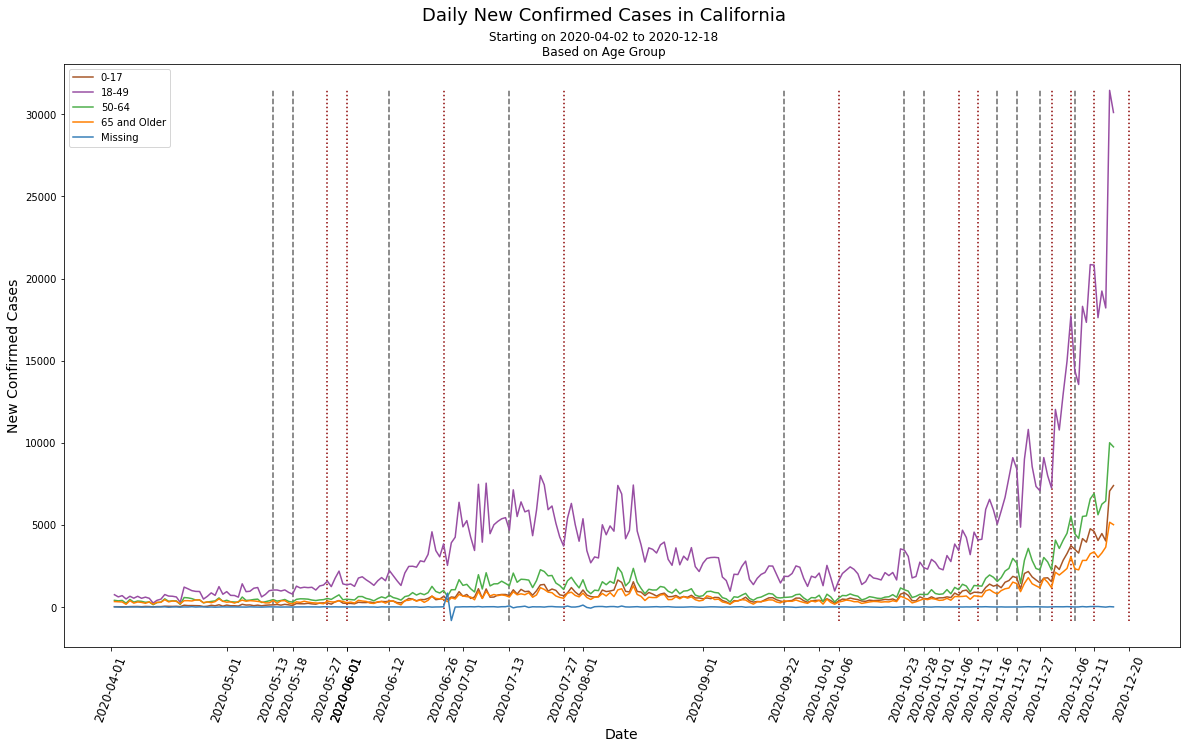

In [114]:
# Colour Blind Friendly Colours
CB_color_cycle = ['#a65628', '#984ea3', '#4daf4a',
                  '#ff7f00', '#377eb8', '#999999',
                  '#e41a1c', '#f781bf', '#dede00']

# Counter for colours
c = 0

fig, ax = plt.subplots(figsize = (20,12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
for age in covid_df['age_group'].unique():
    ax.plot(date_lst, covid_df[covid_df['age_group']==age].drop(['date', 'age_group'], axis = 1)['newconfirmed_age'], c = CB_color_cycle[c])
    c +=1
ax.legend(covid_df['age_group'].unique())
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylabel('New Confirmed Cases', fontsize = 14)
plt.text(x=0.5, y=0.85, s="Daily New Confirmed Cases in California", fontsize=18, ha="center", transform=fig.transFigure)
plt.text(x=0.5, y=0.81, s= f"Starting on 2020-04-02 to 2020-12-18\nBased on Age Group", fontsize=12, ha="center", transform=fig.transFigure)
plt.subplots_adjust(top=0.8, wspace=0.3)
for date in range(len(important_dates)):
    ax.vlines(important_dates[date], ymin = min(covid_df['newconfirmed_age']), ymax = max(covid_df['newconfirmed_age']), colors = 'dimgray', linestyles = 'dashed')
    ax.vlines(two_weeks_later[date], ymin = min(covid_df['newconfirmed_age']), ymax = max(covid_df['newconfirmed_age']), colors = 'darkred', linestyles = 'dotted')

plt.xticks(labels, labels, rotation = 70, fontsize = 12);


### Important Dates:
- March 19th - statewide SIP (2 weeks later - April 2)
- May 13 - LA beaches reopen (2 weeks later - May 27)
- May 18 - Newsom changes reopening parameters (more eased) (2 weeks later - June 1)
- June 12 - indoor businesses like restaurants, retail stores, bars, gyms, and religious services reopen (2 weeks later - June 26)
- July 13 - bars and indoor dining closed again (some counties close gyms, churches, hair salons, etc) (2 weeks later - July 27)
- September 22 - nail salons and salons reopen (2 weeks later - October 6)
- October 23 - State allows nursing home visitors (2 weeks later - November 6)
- October 28 - San Mateo gyms increase capacity from 10% to 25% (2 weeks later - November 11)
- November 16 - Nonessential businnesses close and Californians must wear a mask whenever outside their house (2 weeks later - November 30)
- November 21 - Statewide curfew implemented until December 21 (2 weeks later - December 5)
- November 27 - LA County imposes new stay-at-home order (2 weeks later - December 11)
- December 6 - Bay Area (as well as most counties in California) impose new stay-at-home order (2 weeks later - December 20)

In [48]:
# Upload Age Group data for the US
us_covid_data = pd.read_csv('data/us_cases_by_age_group.csv', skiprows = 2)

In [52]:
us_covid_data

,Age Group,Percentage,Count
0,0 - 4 Years,1.8,220312
1,5 - 17 Years,8.5,1041026
2,18 - 29 Years,23.2,2843241
3,30 - 39 Years,16.5,2020400
4,40 - 49 Years,15.1,1848803
5,50 - 64 Years,20.5,2513112
6,65 - 74 Years,7.7,939971
7,75 - 84 Years,4.1,507977
8,85+ Years,2.6,321992


In [60]:
# Combine Age Groups to match that of the CA Age Group for the Counts
# Age groups for Covid: 0-17, 18-49, 50-64, 65 and Older
us_count_0_17 = us_covid_data[0:2]['Count'].sum()
us_count_18_49 = us_covid_data[2:5]['Count'].sum()
us_count_50_64 = us_covid_data[5:6]['Count'].sum()
us_count_older_65 = us_covid_data[6:]['Count'].sum()
missing_count = 12449803-12382817
counts = [us_count_0_17,us_count_18_49,us_count_50_64,us_count_older_65, missing_count]


In [62]:
# Recalculate the percentage (to the nearest ten thousandths)
total = 12449803
percentages = []

for c in counts:
    percentages.append(round(c/total,5))


In [63]:
# Create DataFrame for Percentage of US Age Groups
age_groups = ['0-17', '18-49', '50-64', '65 and Older', 'Missing']
us_age_percents = pd.DataFrame({'Age Group': age_groups, 'Positive Percentage':percentages, 'Positive Count': counts})
us_age_percents

,Age Group,Positive Percentage,Positive Count
0,0-17,0.10131,1261338
1,18-49,0.53916,6712444
2,50-64,0.20186,2513112
3,65 and Older,0.14217,1769940
4,Missing,0.00538,66986


## Hypothesis Testing: Chi-Square Test

$\chi^2 = \sum \frac{(O - E)^2}{E}$

$H_0$: The positive case percentage for each age group in CA is equal to the positive case percentage for each age group in the US

$H_0: p_1 = 0.10131, p_2 = 0.53916, p_3 = 0.20186, p_4 = 0.14217, p_5 = 0.00538$

* $p_1$ is positive percentage for 0-17 in US
* $p_2$ is positive percentage for 18-49 in US
* $p_3$ is positive percentage for 50-64 in US, 
* $p_4$ is positive percentage for 65 and older in US, and
* $p_5$ is positive percentage for missing in US

$H_a$: The positive percentage for each age group in CA is not equal to the positive percentage for each age group in the US

In [96]:
# Chi-squared test - Goodness of Fit
# Total positive count in CA
CA_total_pos = float(covid_df['totalcountconfirmed'].iloc[-1])

# Create expected list; Make sure to round to nearest whole number
expected = []
for c in range(5):
    expected.append(round(us_age_percents['Positive Percentage'].iloc[c]*CA_total_pos))

# Change list to series
expected_ca = pd.Series(expected)

In [117]:
# Create observed list by slicing (last 5 rows)
observed_ca = covid_df['totalpositive'].iloc[-5:]

In [118]:
stats.chisquare(observed_ca, expected_ca)
# P-value of 0. Reject the null that the positive case percentage for each age group in CA is equal to 
# the positive case percenntage for each age group in US

Power_divergenceResult(statistic=41586.96638522837, pvalue=0.0)

In [115]:
observed_ca

1290    0.11769
1291    0.59190
1292    0.18755
1293    0.10214
1294    0.00072
Name: positive_age_proportion, dtype: float64

In [116]:
expected

[174594.0, 929168.0, 347878.0, 245010.0, 9272.0]